In [381]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
import statsmodels.api as sm

%matplotlib inline

In [67]:
def get_data(coin = 'bitcoin', year = 2017):
    
    df = pd.read_csv(f'./data/{coin}_{year}.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 's')
    df.set_index('timestamp', inplace = True)
    df.sort_index(inplace = True)
    df = df[['Count','Open','High','Low','Close','Volume','VWAP','Target']]
    
    return df

In [68]:
btc2017 = get_data()
btc2018 = get_data('bitcoin', 2018)
btc2019 = get_data('bitcoin', 2019)
btc2020 = get_data('bitcoin', 2020)
btc2021 = get_data('bitcoin', 2021)

In [69]:
btc = pd.concat([btc2017, btc2018, btc2019, btc2020, btc2021], axis = 0)

In [278]:
btc.tail()

,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,
2021-12-22 23:39:00,393.0,48685.09,48688.45,48657.61,48666.75,18.23746,113568.310000,-9.540979e-18
2021-12-22 23:40:00,296.0,48666.74,48667.14,48652.38,48660.47,5.68742,113539.676667,-6.613633e-18
2021-12-22 23:41:00,301.0,48660.47,48663.84,48658.13,48659.31,7.38479,113541.740000,-7.372575e-18
2021-12-22 23:42:00,582.0,48659.31,48659.31,48633.78,48633.80,14.44861,113504.356667,1.321371e-19
2021-12-22 23:43:00,978.0,48633.80,48635.15,48586.68,48594.20,25.04675,113419.896667,5.529431e-18


In [281]:
resample(btc)

,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,
2017-08-17,3.0,4261.48,4261.48,4261.48,4261.48,1.775183,9943.453333,0.000000e+00
2017-08-18,1.0,4285.08,4285.08,4285.08,4285.08,0.022196,9998.520000,3.983590e-03
2017-08-19,5.0,4108.37,4108.37,4108.37,4108.37,0.711854,9586.196667,2.425459e-03
2017-08-20,0.0,4139.98,4139.98,4139.98,4139.98,0.000000,9640.953333,6.368177e-04
2017-08-21,3.0,4069.13,4086.29,4069.13,4086.29,0.255886,9517.516667,3.020648e-03
...,...,...,...,...,...,...,...,...
2021-12-18,1323.0,46133.83,46259.50,46125.98,46216.42,35.268690,107790.953333,-9.540979e-18
2021-12-19,524.0,46834.47,46834.48,46774.44,46789.64,14.206440,109205.466667,-3.144186e-18
2021-12-20,1492.0,46681.24,46684.30,46600.00,46682.93,85.791860,108845.276667,-2.515349e-17


In [300]:
def resample(df, time_period = '1d'):
    df1 = df[['Open']].resample(time_period).first()
    df2 = df[['Close']].resample(time_period).last()
    df3 = df[['Volume']].resample(time_period).sum()
    df = pd.concat([df1,df2,df3], axis = 0).sort_index().groupby('timestamp').sum()
    return df

In [646]:
def add_cols(df):
    
    df['log_open'] = np.log(df['Open'])
    df['log_close'] = np.log(df['Close'])

    #let's make sure this is correct
    df['return'] = np.log(df['Close']/df['Close'].shift(1)).shift(1)
                          
    for i in range(7):
        days_ago = f'close_{i+1}_prior'
        df[days_ago] = df['log_close'].shift(i+1)
    
    df['sma_7'] = df['Close'].rolling(7).mean().shift(1)
    df['sma_30'] = df['Close'].rolling(30).mean().shift(1)
    df['sma_50'] = df['Close'].rolling(50).mean().shift(1)
    df['sma_200'] = df['Close'].rolling(200).mean().shift(1)

    df['dist_sma_7'] = (df['Close'] - df['sma_7']).shift(1)
    df['dist_sma_30'] = (df['Close'] - df['sma_30']).shift(1)
    df['dist_sma_50'] = (df['Close'] - df['sma_50']).shift(1)
    df['dist_sma_200'] = (df['Close'] - df['sma_200']).shift(1)
    
    df['momentum_7'] = df['return'].rolling(7).mean().shift(1)
    df['momentum_30'] = df['return'].rolling(30).mean().shift(1)
    df['momentum_50'] = df['return'].rolling(50).mean().shift(1)
    df['momentum_200'] = df['return'].rolling(200).mean().shift(1)
    
    df['volatility_7'] = df['return'].rolling(7).std().shift(1)
    df['volatility_30'] = df['return'].rolling(7).std().shift(1)
    df['volatility_50'] =  df['return'].rolling(50).std().shift(1)
    df['volatility_200'] = df['return'].rolling(200).std().shift(1)
    
    df['volume_7'] = df['Volume'].rolling(7).mean().shift(1)
    df['volume_14'] = df['Volume'].rolling(14).mean().shift(1)
    df['volume_30'] = df['Volume'].rolling(30).mean().shift(1)
    df['volume_50'] = df['Volume'].rolling(50).mean().shift(1)
    
    df.drop(['Volume'], axis = 1, inplace = True)
    df.dropna(inplace = True)
    
    return df

In [647]:
daily = add_cols(resample(btc))

In [648]:
daily

,Open,Close,log_open,log_close,return,close_1_prior,close_2_prior,close_3_prior,close_4_prior,close_5_prior,...,momentum_50,momentum_200,volatility_7,volatility_30,volatility_50,volatility_200,volume_7,volume_14,volume_30,volume_50
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-07-07,6602.941429,6752.501429,8.795270,8.817668,0.010569,8.794999,8.784430,8.792935,8.780534,8.797065,...,-0.004886,-0.005302,0.027785,0.027785,0.033861,0.053411,74896.827362,80062.843292,83779.893017,81538.060967
2018-07-08,6755.638333,6704.184286,8.818133,8.810487,0.022669,8.817668,8.794999,8.784430,8.792935,8.780534,...,-0.003996,-0.005248,0.020892,0.020892,0.033667,0.053421,70545.218843,79090.881971,83599.824901,81075.744116
2018-07-09,6706.365000,6661.478571,8.810812,8.804097,-0.007181,8.810487,8.817668,8.794999,8.784430,8.792935,...,-0.003979,-0.004703,0.019881,0.019881,0.033680,0.053145,70893.331436,73388.811688,83643.323221,81209.998621
2018-07-10,6662.305714,6302.410000,8.804221,8.748687,-0.006390,8.804097,8.810487,8.817668,8.794999,8.784430,...,-0.004111,-0.004500,0.020048,0.020048,0.033679,0.053057,67323.079659,71106.155748,84323.605457,81369.042204
2018-07-11,6303.092857,6379.651667,8.748796,8.760869,-0.055409,8.748687,8.804097,8.810487,8.817668,8.794999,...,-0.004927,-0.004220,0.014203,0.014203,0.033217,0.052898,70074.414081,73684.409544,81923.513076,82075.280369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-18,46133.830000,46834.480000,10.739302,10.754375,-0.032023,10.739245,10.771268,10.796816,10.786083,10.751558,...,-0.004081,0.001449,0.039128,0.039128,0.034263,0.037913,38916.595751,46384.088133,45794.324466,43946.663427
2021-12-19,46834.470000,46681.230000,10.754375,10.751097,0.015130,10.754375,10.739245,10.771268,10.796816,10.786083,...,-0.005448,0.001065,0.040971,0.040971,0.033980,0.037861,38363.861341,40013.850916,44556.759579,43567.586398
2021-12-20,46681.240000,46914.160000,10.751098,10.756075,-0.003278,10.751097,10.754375,10.739245,10.771268,10.796816,...,-0.005692,0.001221,0.036036,0.036036,0.033783,0.037855,38833.543119,38851.342811,43843.086892,43524.138018


In [306]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1265 entries, 2018-07-07 to 2021-12-22
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            1265 non-null   float64
 1   Close           1265 non-null   float64
 2   log_close       1265 non-null   float64
 3   return          1265 non-null   float64
 4   close_1_prior   1265 non-null   float64
 5   close_2_prior   1265 non-null   float64
 6   close_3_prior   1265 non-null   float64
 7   close_4_prior   1265 non-null   float64
 8   close_5_prior   1265 non-null   float64
 9   close_6_prior   1265 non-null   float64
 10  close_7_prior   1265 non-null   float64
 11  sma_7           1265 non-null   float64
 12  sma_30          1265 non-null   float64
 13  sma_50          1265 non-null   float64
 14  sma_200         1265 non-null   float64
 15  dist_sma_7      1265 non-null   float64
 16  dist_sma_30     1265 non-null   float64
 17  dist_sma_50    

In [307]:
corrs = daily.corr().stack().reset_index()
corrs.columns = ['1','2','R2']
corrs[(corrs.R2 > .8) & (corrs.R2 < 1)].sort_values('R2', ascending = False)

,1,2,R2
126,close_1_prior,log_close,0.998982
66,log_close,close_1_prior,0.998982
129,close_1_prior,close_2_prior,0.998981
159,close_2_prior,close_1_prior,0.998981
161,close_2_prior,close_3_prior,0.998980
...,...,...,...
438,sma_200,close_1_prior,0.863708
76,log_close,sma_200,0.862346
436,sma_200,log_close,0.862346
641,momentum_30,momentum_50,0.801538


In [249]:
def create_lags(df, col = 'log_close', lags = 7):
    
    for i in range(1, lags+1):
        col_name = f'lag_{i}'
        df[col_name] = df['log_close'].shift(i)
    df.dropna(inplace = True)
        
    return df

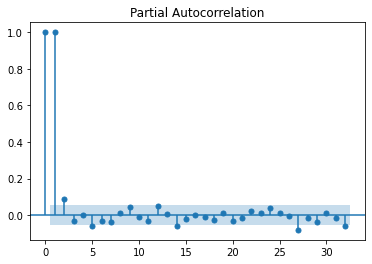

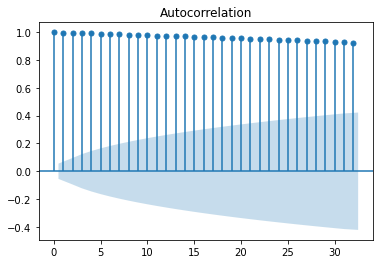

In [250]:
plot_pacf(daily['log_close']);
plot_acf(daily['log_close']);

In [251]:
def simple_moving_average(df, windows = [7,50,200]):
    for i in windows:
        col = f'sma_{i}'
        df[col] = df['Close'].rolling(i, min_periods = int(i*.75)).mean()
        df[col].plot(figsize = (40,10), legend = True, subplots = False)
    
    df['Close'].plot(legend = True);
    return df

In [252]:
def decomposition_plot(df):
        '''Takes time series dataframe and decompose it in order to observe trend, seasonality, and residuals'''
        decomposition = tsa.seasonal_decompose(df, period = 1, model = 'multiplicative', freq = 7)
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
        plt.figure(figsize=(10,7))
        plt.subplot(511)
        plt.plot(ts, label='Original', color='red')
        plt.legend(loc='best')
        plt.subplot(512)
        plt.plot(trend, label='Trend', color='blue')
        plt.legend(loc='best')
        plt.subplot(513)
        plt.plot(seasonal,label='Seasonality', color='orange')
        plt.legend(loc='best')
        plt.subplot(514)
        plt.plot(residual, label='Residuals', color='black')
        plt.legend(loc='best')
        plt.tight_layout()

In [253]:
### Seasonal Decomposition
def seasonal_decomposition(df):
    periods = [1,3,7,30,50,365]
    model = ['multiplicative', 'additive']

    combinations = []
    for x in periods:
        for y in model:
            combinations.append((x,y))
    
    adfullercombinations = []

    for i in combinations:
        components = tsa.seasonal_decompose(df, period = i[0], model = i[1])
        trend = components.trend
        seasonal = components.seasonal
        residual = components.resid
        observed = components.observed
        x = adfuller(residual.dropna())
        if x[1] < .05:
            adfullercombinations.append([i,x])
    
    return adfullercombinations

In [259]:
mod_arma = ARMA(x, order=(1,0))
res_arma = mod_arma.fit()
print(res_arma.summary())

                              ARMA Model Results                              
Dep. Variable:              log_close   No. Observations:                 1265
Model:                     ARMA(1, 0)   Log Likelihood                2288.367
Method:                       css-mle   S.D. of innovations              0.040
Date:                Tue, 04 Jan 2022   AIC                          -4570.733
Time:                        17:24:19   BIC                          -4555.305
Sample:                    07-07-2018   HQIC                         -4564.937
                         - 12-22-2021                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               9.6815      0.775     12.497      0.000       8.163      11.200
ar.L1.log_close     0.9991      0.001   1154.782      0.000       0.997       1.001
                                

In [261]:
mod2_arma = ARMA(x, order=(0,1))
res2_arma = mod2_arma.fit()
print(res2_arma.summary())

                              ARMA Model Results                              
Dep. Variable:              log_close   No. Observations:                 1265
Model:                     ARMA(0, 1)   Log Likelihood                -806.023
Method:                       css-mle   S.D. of innovations              0.457
Date:                Tue, 04 Jan 2022   AIC                           1618.046
Time:                        17:24:30   BIC                           1633.474
Sample:                    07-07-2018   HQIC                          1623.842
                         - 12-22-2021                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               9.4679      0.025    374.768      0.000       9.418       9.517
ma.L1.log_close     0.9665      0.006    172.190      0.000       0.955       0.977
                                

In [220]:
#p: The number of lag observations included in the model, also called the lag order.
#d: The number of times that the raw observations are differenced, also called the degree of differencing.
#q: The size of the moving average window, also called the order of moving average.

In [308]:
test_size = 3

x = daily.drop('log_close', axis = 1)
x_train = x.head(len(x) - test_size)
x_test = x.tail(test_size)

y = daily['log_close']
y_train = y.head(len(y) - test_size)
y_test = y.tail(test_size)

In [309]:
aic_scores = []

train_size = [len(y_train),500,250,100,50]

for p in range(3):
    for q in range(1,3):
        for d in range(3):
            for size in train_size:
                model = ARIMA(endog = y_train.tail(size), exog = x_train.tail(size), order =(p,q,d))
                fitmodel = model.fit()
                y_preds = fitmodel.forecast(test_size, exog = x_test)
                rmse = np.sqrt(mean_squared_error(np.exp(y_test),np.exp(y_preds)))
                aic_scores.append(pd.DataFrame([size, (a,b,c), fitmodel.aicc, rmse]).T)

In [310]:
ARIMAX_df = pd.concat(aic_scores, axis = 0)
ARIMAX_df.set_axis(['train_size', 'order', 'AIC', 'RMSE'], axis = 1, inplace = True)

In [311]:
ARIMAX_df.sort_values('RMSE').head(10)

,train_size,order,AIC,RMSE
0,250,"(2, 2, 2)",-1649.1,57.561
0,250,"(2, 2, 2)",-1647.99,60.4156
0,250,"(2, 2, 2)",-1652.47,61.4624
0,250,"(2, 2, 2)",-1649.77,61.9562
0,250,"(2, 2, 2)",-1652.27,61.9965
0,250,"(2, 2, 2)",-1650.61,74.4667
0,250,"(2, 2, 2)",-1653.11,74.9388
0,250,"(2, 2, 2)",-1653.11,75.1188
0,250,"(2, 2, 2)",-529.851,75.5681
0,500,"(2, 2, 2)",-2782.07,79.8691


In [312]:
ARIMAX_df.sort_values('AIC').head(20)

,train_size,order,AIC,RMSE
0,1262,"(2, 2, 2)",-5526.78,441.213
0,1262,"(2, 2, 2)",-5526.78,441.216
0,1262,"(2, 2, 2)",-5525.19,436.136
0,1262,"(2, 2, 2)",-5525.17,436.246
0,1262,"(2, 2, 2)",-5524.66,441.296
0,1262,"(2, 2, 2)",-5523.18,435.746
0,1262,"(2, 2, 2)",-5523.05,436.351
0,1262,"(2, 2, 2)",-5521.16,439.486
0,1262,"(2, 2, 2)",-5305.35,670.135
0,1262,"(2, 2, 2)",-5305.1,698.273


In [623]:
def backtesting(df, start_date = '2021-10-1', train_size = 250, test_size = 60):
    
    date = datetime.strptime(start_date, '%Y-%m-%d')
    
    earliest = date - timedelta(train_size)
    latest = date + timedelta(test_size)
    
    d = pd.date_range(start = date, end = latest)
    data = df[(df.index >= earliest) & (df.index <= latest)]
    
    X = data.drop(['log_close'], axis = 1)
    y = data['log_close']
    
    predictions = []
    
    for date in d:
        
        y_train = y[y.index < date][-(train_size):]
        X_train = X[X.index < date][-(train_size):]
        y_test = y[y.index == date]
        X_test = X[X.index == date]
        
        model = ARIMA(endog = y_train, exog = X_train, order =(2,2,2))
        fitmodel = model.fit()
        y_pred = fitmodel.forecast(1, exog = X_test)
        diff = np.exp(y_test[0]) - np.exp(y_pred[0])
        predictions.append([date, np.exp(y_pred)[0]])
    
    preds = pd.DataFrame(predictions, columns = ['timestamp', 'prediction']).set_index('timestamp')
    print(preds.index)
    df2 = data.merge(preds, on = 'timestamp')
    df2['log_predicted_return'] = np.log(df2['prediction'] / df2['Open'])
    
    return df2
        
   

In [624]:
first_preds = backtesting(daily, train_size = 50, test_size = 10)

DatetimeIndex(['2021-10-01', '2021-10-02', '2021-10-03', '2021-10-04',
               '2021-10-05', '2021-10-06', '2021-10-07', '2021-10-08',
               '2021-10-09', '2021-10-10', '2021-10-11'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


In [625]:
first_preds

,Open,Close,log_open,log_close,return,close_1_prior,close_2_prior,close_3_prior,close_4_prior,close_5_prior,...,volatility_7,volatility_30,volatility_50,volatility_200,volume_7,volume_14,volume_30,volume_50,prediction,log_predicted_return
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-10-01,43825.73,48141.61,10.687976,10.781902,0.053906,10.687939,10.634034,10.621974,10.648927,10.672690,...,0.026918,0.026918,0.036426,0.042089,47385.731363,61663.206217,81395.812410,84026.463446,48204.963929,0.095241
2021-10-02,48141.60,47634.90,10.781902,10.771321,0.093963,10.781902,10.687939,10.634034,10.621974,10.648927,...,0.033172,0.033172,0.037271,0.042202,44829.934671,61783.642983,80478.598429,83240.099920,47513.792989,-0.013127
2021-10-03,47634.89,48200.01,10.771321,10.783115,-0.010581,10.771321,10.781902,10.687939,10.634034,10.621974,...,0.043484,0.043484,0.039428,0.042542,44389.136017,59929.309173,78162.095301,81877.001746,48117.659454,0.010084
2021-10-04,48200.01,49224.94,10.783115,10.804156,0.011794,10.783115,10.771321,10.781902,10.687939,10.634034,...,0.044128,0.044128,0.038052,0.042516,41667.001497,58306.248440,75517.608315,80826.259638,49341.367048,0.023404
2021-10-05,49224.93,51471.99,10.804155,10.848793,0.021041,10.804156,10.783115,10.771321,10.781902,10.687939,...,0.044122,0.044122,0.038023,0.042450,42669.808624,49825.923508,75056.303388,80160.697197,51625.939442,0.047624
2021-10-06,51471.99,55315.00,10.848793,10.920799,0.044637,10.848793,10.804156,10.783115,10.771321,10.781902,...,0.040534,0.040534,0.038132,0.042453,43920.295129,47516.271424,74334.657348,79223.142962,55570.988695,0.076624
2021-10-07,55315.00,53785.22,10.920799,10.892754,0.072006,10.920799,10.848793,10.804156,10.783115,10.771321,...,0.034682,0.034682,0.038457,0.042571,50391.117344,49054.020692,74131.732360,78585.150307,53437.346308,-0.034534
2021-10-08,53785.22,53951.43,10.892754,10.895839,-0.028045,10.892754,10.920799,10.848793,10.804156,10.783115,...,0.036190,0.036190,0.039454,0.042880,51610.567323,49498.149343,67735.054175,77637.898878,54118.625098,0.006180
2021-10-09,53955.67,54949.72,10.895918,10.914174,0.003085,10.895839,10.892754,10.920799,10.848793,10.804156,...,0.043768,0.043768,0.039715,0.042916,48744.482809,46787.208740,64898.739049,76553.469319,55157.778325,0.022035


In [639]:
first_preds['buy'] = np.where(first_preds['prediction'] > first_preds['Open'],first_preds['return'],0)

In [650]:
first_preds['prediction'] - first_preds['Open']

timestamp
2021-10-01    4379.233929
2021-10-02    -627.807011
2021-10-03     482.769454
2021-10-04    1141.357048
2021-10-05    2401.009442
2021-10-06    4098.998695
2021-10-07   -1877.653692
2021-10-08     333.405098
2021-10-09    1202.108325
2021-10-10    -593.296248
2021-10-11    3471.113303
dtype: float64

In [651]:
first_preds['Close'] - first_preds['Open']

timestamp
2021-10-01    4315.88
2021-10-02    -506.70
2021-10-03     565.12
2021-10-04    1024.93
2021-10-05    2247.06
2021-10-06    3843.01
2021-10-07   -1529.78
2021-10-08     166.21
2021-10-09     994.05
2021-10-10    -290.72
2021-10-11    2812.34
dtype: float64